<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of the Multilevel dataset

Here we compute for each sample the coarse FEM solution that will then be given as imput to the NN of the fine level

#### Import libraries

In [1]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
from itertools import product
import timeit
import pandas as pd 
from keras.optimizers import Adam,Nadam,Adamax
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.utils import extmath
from fenics import *

import sys
sys.path.append('./solver')
from model import *
#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

2024-07-12 15:13:59.771860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import the dataset 

In [5]:
X_train = np.loadtxt('./data/X_train.csv', delimiter = ',')
y_train = np.loadtxt('./data/y_train.csv', delimiter = ',')

X_test = np.loadtxt('./data/X_test.csv', delimiter = ',')
y_test = np.loadtxt('./data/y_test.csv',delimiter = ',')

In [5]:
# Set the resolution of the model and the random field parameters.
resolution_fine = (50, 50)
resolution_coarse = (25, 25)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64

# set dataponts
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
#x_data = y_data = np.linspace(0,1,26)
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)

# Set up the model(s)
solver_c = Model(resolution_coarse, field_mean, field_stdev, mkl, lamb_cov)
solver_f = Model(resolution_fine, field_mean, field_stdev, mkl, lamb_cov)


def solver_fine(x):
    solver_f.solve(x)
    return solver_f.get_data(datapoints)


def solver_coarse(x):
    solver_c.solve(x)
    return solver_c.get_data(datapoints)

Calculate the dataset that will be used to train the multilevel NN 

In [7]:
coarse_sol = np.zeros((57600, n_datapoints))
for i in range( 57600 ):
    coarse_sol[i, :] = solver_coarse(X_train[i, :])

X_full_train = np.hstack((X_train, coarse_sol))

fine_sol = np.zeros((6400, n_datapoints))
for i in range( 6400 ):
    fine_sol[i, :] = solver_coarse(X_test[i, :])

X_full_test = np.hstack((X_test, fine_sol))

np.savetxt("./data/X_full_train.csv", X_full_train, delimiter = ",")
np.savetxt("./data/X_full_test.csv", X_full_test, delimiter = ",")

# Generation of the dataset for the POD-based multilevel HF NN 

### Generation of the coarse-field for each sample

In [ ]:
# Set the resolution of the model and the random field parameters.
resolution_fine = (50, 50)
resolution_coarse = (25, 25)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64
# set dataponts
x_data = y_data = np.linspace(0,1,26)
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)
# Set up the model(s)
solver_c = Model(resolution_coarse, field_mean, field_stdev, mkl, lamb_cov)


def solver_coarse(x):
    solver_c.solve(x)
    return solver_c.get_data(datapoints)


coarse_sol_train = np.zeros((57600, n_datapoints))
for i in range( 57600 ):
    coarse_sol_train[i, :] = solver_coarse(X_train[i, :])

coarse_sol_test = np.zeros((6400, n_datapoints))
for i in range( 6400 ):
    coarse_sol_test[i, :] = solver_coarse(X_test[i, :])

In [6]:
done = True 
if not done:
    np.savetxt("./data/coarse_sol_train.csv",coarse_sol_train , delimiter = ",")
    np.savetxt("./data/coarse_sol_test.csv",coarse_sol_test , delimiter = ",")

coarse_sol_train = np.loadtxt("./data/coarse_sol_train.csv" , delimiter = ",")
coarse_sol_test = np.loadtxt("./data/coarse_sol_test.csv" , delimiter = ",")

### Extraction of the POD and identification of number of components 

I want $A \in R^{m\times n }$ with m dimention of output and n number of samples  

In [10]:
n = 10000
y_t = coarse_sol_train[0:n,:].T
y_t.shape

(676, 10000)

In [11]:
U, S, Vh = np.linalg.svd(y_t)
U.shape, S.shape, Vh.shape

((676, 676), (676,), (10000, 10000))

In [33]:
U[0:4,0:5]

array([[-0.06546444, -0.05749896, -0.00026696, -0.05920777, -0.00175937],
       [-0.06546444, -0.05749896, -0.00026696, -0.05920777, -0.00175937],
       [-0.06546444, -0.05749896, -0.00026696, -0.05920777, -0.00175937],
       [-0.06546444, -0.05749896, -0.00026696, -0.05920777, -0.00175937]])

Understand how many components would be useful to retain 

[0.60471273 0.65145979 0.68401852 0.70956627 0.73226776 0.7476212
 0.76256401 0.77618292 0.78966797 0.80024268 0.81038143 0.82035347
 0.82823303 0.83592088 0.84319789 0.85004146 0.8567591  0.86291566
 0.86853848 0.87399422 0.87866552 0.88321254 0.88768747 0.89207976
 0.89629966 0.90016512 0.90380416 0.90722645 0.91033245 0.91338571
 0.916412   0.91925717 0.92198226 0.92466029 0.92728453 0.92958446
 0.93184378 0.93400774 0.93613371 0.938237   0.94030959 0.94211854
 0.94390763 0.94558314 0.94724911 0.94887082 0.95044192 0.9518176
 0.9531624  0.95424304 0.95527002 0.95628212 0.95728583 0.95827763
 0.95925126 0.96014436 0.96100226 0.96184044 0.96264123 0.9634338
 0.96420239 0.9649635  0.96567582 0.96638155 0.96708211 0.96775497
 0.96842621 0.96903734 0.96963726 0.97021369] .....


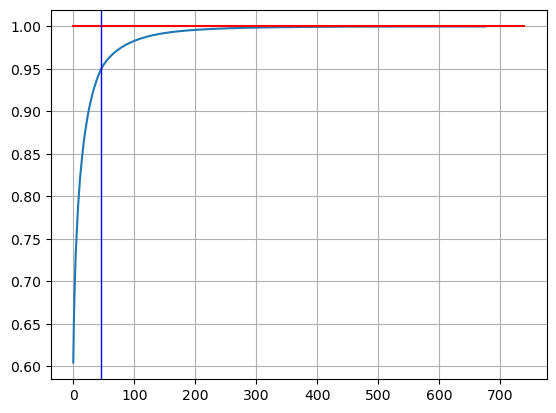

In [13]:
#print('S is:', S)
v = np.cumsum(S)/np.sum(S)
print(v[0:70], '.....')
plt.plot(v, '-')
plt.grid()
plt.plot(np.ones(740), 'red')
plt.axvline(x=46, color='b', linestyle='-', linewidth=1)
plt.show()


Check the convergence of the first 5 components 

[1. 1. 1. 1. 1.]
[0.00172227 0.05138503 0.10841294 0.17843499 0.15014369]
[0.00106599 0.01725072 0.01738794 0.03015264 0.0242204 ]
[0.00088869 0.01490209 0.03450164 0.06789632 0.06259907]
[0.00055103 0.01517281 0.03329196 0.01693244 0.03840014]
[0.00045412 0.00668725 0.01829665 0.02874394 0.02913891]
[0.00069323 0.01437344 0.02002601 0.01888386 0.0169214 ]
[0.00075401 0.00813037 0.00943799 0.01461163 0.01243982]
[0.00036893 0.00568195 0.01196598 0.0144799  0.00708793]
[0.00037071 0.00695645 0.00864379 0.01411438 0.01543674]
[0.00034994 0.00482935 0.00519091 0.01490246 0.015169  ]
[0.00034916 0.00753935 0.00991049 0.01191371 0.01126832]
[0.00042818 0.00418912 0.01046209 0.01631529 0.01479459]
[0.0001815  0.00384042 0.00451141 0.00849613 0.00921949]
[0.00015635 0.00503084 0.00789314 0.00458136 0.0076977 ]


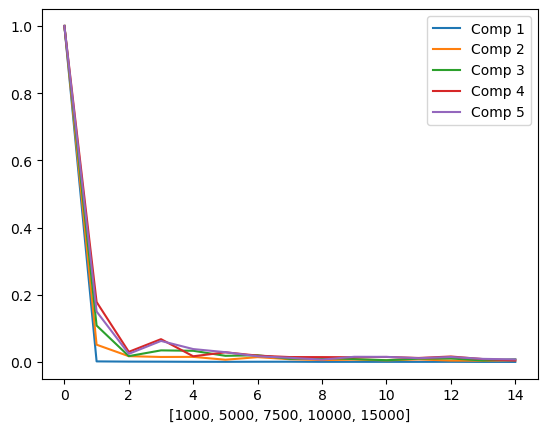

In [38]:
n_comp = 5
values = [1000,2000, 3000, 4000, 5000,6000,7000, 8000, 9000, 10000,11000,12000, 13000, 14000, 15000]
l = len(values)

diff = np.zeros((n_comp,l))
b = np.zeros((676, n_comp))

for i, n in enumerate(values):
    U2, S2, Vh2 = np.linalg.svd(coarse_sol_train[0:n,:].T)
    diff[:,i] = np.linalg.norm((b-np.abs(U2[:, 0:n_comp])), axis=0)
    b =  np.abs(U2[:, 0:n_comp])
    print(diff[:,i])
    

#plt.yscale("log")
for i in range(n_comp):
    plt.plot(diff[i,:])
plt.xlabel([1000, 5000, 7500, 10000, 15000])
plt.legend(['Comp 1','Comp 2', 'Comp 3', 'Comp 4', 'Comp 5'] )
plt.show()

### Definition of the POD dataset 

In [39]:
#########################   PROJECTION ONTO POD BASIS    ##########################
n_comp = 46 # number of components to retain 

basis = U[:,0:n_comp]
X_train_pod = coarse_sol_train @ basis
X_test_pod = coarse_sol_test @ basis

In [40]:
np.savetxt("./data/X_train_pod.csv",X_train_pod , delimiter = ",")
np.savetxt("./data/X_test_pod.csv",X_test_pod , delimiter = ",")
np.savetxt("./data/POD_basis.csv", basis, delimiter=',')

### Definition of the adjustment response 

The output of the high fidelity will have as objective to indentify the error made by the low fidelity model. 
Here it therefore computed the error dataset that will the be used in the training of the aforementioned model 

In [89]:
x_data = y_data = [0.1, 0.3, 0.5, 0.7, 0.9]
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)
# Set up the model(s)
solver_c = Model(resolution_coarse, field_mean, field_stdev, mkl, lamb_cov)


def solver_coarse(x):
    solver_c.solve(x)
    return solver_c.get_data(datapoints)


coarse_sol = np.zeros((57600, n_datapoints))
for i in range( 57600 ):
    coarse_sol[i, :] = solver_coarse(X_train[i, :])

coarse_sol_t = np.zeros((6400, n_datapoints))
for i in range( 6400 ):
    coarse_sol_t[i, :] = solver_coarse(X_test[i, :])

KeyboardInterrupt: 

In [15]:
coarse_sol_t = np.zeros((6400, n_datapoints))
for i in range( 6400 ):
    coarse_sol_t[i, :] = solver_coarse(X_test[i, :])

In [90]:
y_train_adj = y_train - coarse_sol
y_test_adj = y_test - coarse_sol_t

NameError: name 'coarse_sol_t' is not defined

In [19]:
np.savetxt("./data/y_train_adj.csv",y_train_adj , delimiter = ",")
np.savetxt("./data/y_test_adj.csv",y_test_adj , delimiter = ",")